# **I. Preparation**

## A. Imports

In [ ]:
#!pip install lime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import statistics as stat
import sys

from importlib import reload

#import lime
#import lime.lime_tabular

from imblearn.over_sampling import SMOTE

from scipy.stats import uniform

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from xgboost import plot_importance

# Constants
PATH = '/content/drive/My Drive/Colab Notebooks/ocr_data_scientist/P7 Modèle de scoring/'

os.chdir(PATH)
if PATH not in sys.path:
    sys.path.append(PATH)

import std_eda
import std_q7
import std_piechart
import std_pareto
import std_histogram
reload(std_eda)
reload(std_q7)
reload(std_piechart)
reload(std_pareto)
reload(std_histogram)

# Options
sns.set_theme(style="darkgrid")
pd.set_option('display.max_colwidth', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
!pip freeze > requirements.lock.txt

## B. Uploads

In [4]:
train_df = pd.read_csv(PATH + 'data/app_train.csv', sep=',')
test_df = pd.read_csv(PATH + 'data/app_test.csv', sep=',')
cat_col = pd.read_csv(PATH + 'data/categorical_features.csv', sep=',')
app_train_df = pd.read_csv(PATH + 'data/application_train.csv', sep=',')

## C. Inputs check

In [ ]:
train_df.shape

(307508, 306)

In [ ]:
test_df.shape

(48744, 305)

In [ ]:
#train_df.drop('SK_ID_CURR', axis=1, inplace=True)
#test_df.drop('SK_ID_CURR', axis=1, inplace=True)

([<matplotlib.patches.Wedge at 0x7f34cab30690>,
 [Text(-0.45840470672487627, -0.9999325601521737, 'Train set'),
  Text(0.4584047067248764, 0.9999325601521736, 'Test_set')],
 [Text(-0.25003893094084156, -0.5454177600830038, '86.3'),
  Text(0.2500389309408416, 0.5454177600830037, '13.7')])

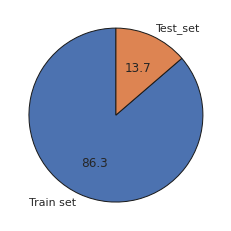

In [ ]:
plt.pie(x=[train_df.shape[0], test_df.shape[0]],
        labels=['Train set', 'Test_set'],
        autopct=lambda x: round(x, 1),
        startangle=90,
        wedgeprops={'edgecolor':'k', 'linewidth': 1})

# **II. Modelisation**

## Settings

In [ ]:
# Take a sample of the original dataframes
train_samp_df = train_df.sample(frac=0.001, random_state=1)
test_samp_df = test_df.sample(frac=0.001, random_state=1)

# Set train and validation set 
X = train_samp_df.drop('TARGET', axis=1)
targets = train_samp_df['TARGET']

# Split the whole set
# The smallest part will be used to choose the best algorithm.
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    targets,
    test_size=0.2,
    random_state=1)

# Split the trainval set
# The smallest part will be used for the validation phase.
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.2,
    random_state=1)

## Fonctions

In [ ]:
def split_oversample_fit(X, y, model):
    '''
    Perform split, oversampling and fitting on the given X and y sets
    '''
    # Train / test split
    X_train, X_val, y_train, y_val = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=1)
    # Oversampling
    X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
    X_resampled = pd.DataFrame(data=X_resampled,
                               columns=X.columns)
    #X_resampled['TARGET'] = pd.Series(y_resampled)
    # Fit the model
    model.fit(X_resampled, y_resampled)

    return model, X_val, y_val


def class_model_perf(X, targets, model):
    '''
    Designed for a binary classification, two categories in total.
    Important: the model must be already instantiated.
    '''

    model, X_val, y_val = split_oversample_fit(X, targets, model)

    # Accuracy
    accuracy = round(model.score(X_val, y_val), 3)
    
    # Confusion matrix elements
    y_pred = model.predict(X_val)
    # Get the false predictions
    pred_dict = dict(pd.Series(y_val - y_pred).value_counts())
    if -1.0 in pred_dict.keys():
        n_FP = pred_dict[-1.0]
    else:
        n_FP = 0
    if 1.0 in pred_dict.keys():
        n_FN = pred_dict[1.0]
    else:
        n_FN = 0
    # Get the true predictions
    temp_dict = dict(pd.Series(2 * y_val - y_pred).value_counts())
    if 1.0 in temp_dict.keys():
        n_TP = temp_dict[1.0]
    else:
        n_TP = 0
    
    try:
        # Precision
        precision = round(n_TP / (n_TP + n_FP), 4)

        # Recall
        recall = round(n_TP / (n_TP + n_FN), 4)
    except ZeroDivisionError:
        return 'n_FP: {}, n_FN: {}, n_TP: {}.'.format(n_FP, n_FN, n_TP)

    # f1 score
    f1 = round(f1_score(y_val, y_pred), 4)

    return 'Accuracy: {}, Precision: {}, Recall: {}, f1-score: {}'.format(
        accuracy, precision, recall, f1)


def list_sample(my_list, chunk):
    '''
    Let a list be given, we select every 'chunk' element.
    Return a list of the selected elements.
    '''
    y = zip(*[iter(my_list)]*chunk)
    return [element[0] for element in y]


def plot_precision_recall_curve(model, X, targets, chunk=1):
    '''

    '''
    model, X_val, y_val = split_oversample_fit(X, targets, model)
    
    precision, recall, threshold = precision_recall_curve(
        y_val,
        model.predict_proba(X_val)[:, 1])
    f1_score = 2 * precision * recall / (precision + recall)
    # In the cas of overlapping points, select a sample of the lists
    precision = list_sample(precision, chunk)
    precision = np.array(precision)
    recall = list_sample(recall, chunk)
    recall = np.array(recall)
    f1_score = list_sample(f1_score, chunk)
    f1_score = np.array(f1_score)
    max_f1 = round(max(f1_score), 3)

    plt.figure(figsize=(8, 8))
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    close_default = np.argmin(np.abs(threshold - 0.5))
    plt.scatter(precision,
                recall,
                s=f1_score*2000,
                c=f1_score,
                cmap='Reds_r',
                edgecolors='k',
                alpha=0.5,
                label='Max f1_score: {}'.format(max_f1))
    plt.plot(precision[close_default//chunk-1],
            recall[close_default//chunk-1],
            '^',
            c='k',
            markersize=10,
            label='Threshold: 0.5',
            fillstyle='none',
            mew=2)
    # ADDITIONAL curves
    x = list(range(0, 100))
    x = [element/100 for element in x]
    # Line of equation y = x
    plt.plot(x, x, color='k', linewidth=1)
    plt.legend(loc='best')
    plt.axis('square')


# Faire en sorte que targets et y_pred puissent être soustrait l'un à l'autre 
# quelque soit leur type

def check_prediction_costs():
    '''
    1. Check inputs of prediction_costs.
    2. 
    '''


def prediction_costs(model, X, targets, y_pred=None):
    '''
    Return the sum of: 
    - the cost of false positives,
    - the cost of false negatives.
    '''
    # Add the prediction errors to the original dataframe
    if type(y_pred) in [list, type(pd.DataFrame()), type(pd.Series())]:
        y_pred = np.array(y_pred)
    if not y_pred.any():
        y_pred = model.predict(X)
    targets = np.array(targets)
    targets = targets.reshape((-1,1))
    y_pred = y_pred.reshape((-1,1))
    X['Prediction error'] = targets - y_pred
    # Create a new feature, multiplying the difference by a money feature.
    # This will be choosen based on feature importances.
    # FP costs
    # log_AMT_ANNUITY_prev: Annuity of previous application
    # AMT_CREDIT_SUM_DEBT: Current debt on Credit Bureau credit.
    # Although useful, it is absent of test set, thus cannot be used. 
    FP_list = []
    for i, row in X.iterrows():
        if X['Prediction error'].loc[i] == -1:
            FP_list.append(-X['Prediction error'].loc[i] *
                           X['log_AMT_ANNUITY_prev'].loc[i])
    FP_sum = sum(FP_list)
    # FN costs
    # log_AMT_ANNUITY: Loan annuity
    FN_list = []
    for i, row in X.iterrows():
        if X['Prediction error'].loc[i] == 1:
            FN_list.append(X['Prediction error'].loc[i] *
                           X['log_AMT_ANNUITY'].loc[i])
    FN_sum = sum(FN_list)
    # Remove the temporary column from X
    X.drop('Prediction error', axis=1, inplace=True)

    return FP_sum + FN_sum


def costs_estimation(model, X, targets, chunk=1):
    '''
    Evaluate the cost for different values of threshold
    '''
    # Prepare for y_pred computation
    pred_proba = model.predict_proba(X)
    predict = [element[1] for element in pred_proba]
    precision, recall, thresholds = precision_recall_curve(
        targets,
        model.predict_proba(X)[:, 1])
    
    # In the cas of overlapping points, select a sample of the lists
    precision = list_sample(precision, chunk)
    precision = np.array(precision)
    recall = list_sample(recall, chunk)
    recall = np.array(recall)
    thresholds = list_sample(thresholds, chunk)
    thresholds = np.array(thresholds)

    # Evaluate costs for different values of threshold
    y_costs = []
    for threshold in list(thresholds):
        # Compute y_pred
        y_pred = []
        for element in predict:
            if element >= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
        # Compute the costs
        y_costs.append(prediction_costs(model,
                                        X,
                                        targets,
                                        y_pred))

    # Set the 3 lists at the same size
    precision = list(precision)
    recall = list(recall)
    thresholds = list(thresholds)
    temp_min = min(len(precision), len(recall), len(thresholds), len(y_costs))
    precision = precision[:temp_min]
    recall = recall[:temp_min]
    thresholds = thresholds[:temp_min]
    y_costs = y_costs[:temp_min]
    return precision, recall, y_costs, thresholds


def costs_curve(model, X, targets, chunk=1):
    '''
    Display the precision / recall curve, the size and color of each point
    representing its corresponding cost.
    '''
    
    model, X_val, y_val = split_oversample_fit(X, targets, model)
    # get the 
    precision, recall, y_costs, thresholds = costs_estimation(model,
                                                              X_val,
                                                              y_val,
                                                              chunk=chunk)
    # Plot the graph
    plt.figure(figsize=(8, 8))
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    thresholds = [element - 0.5 for element in thresholds]
    close_default = np.argmin(np.abs(thresholds))
    plt.scatter(precision,
                recall,
                s=y_costs,
                c=y_costs,
                cmap='Reds',
                edgecolors='k',
                alpha=0.5)
    plt.plot(precision[close_default//chunk-1],
            recall[close_default//chunk-1],
            '^',
            c='k',
            markersize=10,
            label='Threshold: 0.5',
            fillstyle='none',
            mew=2)
    # Line of equation y = x
    x = list(range(0, 100))
    x = [element/100 for element in x]
    plt.plot(x, x, color='k', linewidth=1)
    plt.legend(loc='best')
    plt.axis('square')


def plot_ROC_curve(model, X, targets):
    '''

    '''
    fpr, tpr, threshold = roc_curve(targets,
                                    model.predict_proba(X)[:, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR (recall)')
    plt.title('ROC curve')
    # Line of equation y = x
    x = list(range(0, 100))
    x = [element/100 for element in x]
    plt.plot(x, x, color='k', linewidth=1)
    plt.axis('square')
    plt.plot(fpr, tpr)


def lowest_costs_param(model, X, targets):
    '''
    Return the lowest cost obtained.
    '''
    precision, recall, costs, thresholds = costs_estimation(model,
                                                            X,
                                                            targets)
    precision = [round(element, 2) for element in precision]
    recall = [round(element, 2) for element in recall]
    thresholds = [round(element, 3) for element in thresholds]
    costs = [round(element, 3) for element in costs]
    df = pd.DataFrame({'Precision':precision,
                    'Recall':recall,
                    'Cost':costs,
                    'Threshold':thresholds})
    df.sort_values(by='Cost', inplace=True)
    return dict(df.iloc[0])


def plot_feature_importances(model, X, n_feat):
    '''
    Display a histogram of the feature importances, sorted from the most
    important to the least important.
    '''
    feature_importances = pd.Series(model.feature_importances_,
                                    index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    feature_importances = feature_importances[:n_feat]
    plt.bar(range(len(feature_importances)),
            feature_importances,
            edgecolor='k')


def feature_importance_cumsum(model, df, filter=None):
    '''

    '''
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)
    forest_importances = pd.Series(importances,
                                   index=X.columns)
    forest_importances.sort_values(ascending=False,
                                   inplace=True)
    if filter:
        # Sort and filter the first 10% 
        ratio = len(forest_importances)//10
        forest_importances = forest_importances[:ratio]
        forest_importances
    plt.plot(forest_importances.cumsum())


def most_important_features(model, X, n_feat=6):
    '''
    Display the n most important feature.
    '''
    feature_importances = pd.Series(model.feature_importances_,
                                    index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    feature_importances = feature_importances[:n_feat]
    return feature_importances


def plot_important_features(feature_importances):
    '''
    
    '''
    plt.barh(feature_importances.index,
             feature_importances)


def prediction_with_threshold(predict_proba, threshold=0.5):
    '''
    
    '''
    # Select positive prediction
    predict_proba = predict_proba[:, 1]
    # Form the y_pred
    y_pred = []
    for element in predict_proba:
        if element >= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred = pd.Series(data=y_pred)
    return y_pred

## A. Dummy classifier

In [ ]:
# Instanciation
model = DummyClassifier(strategy='constant', constant=1)
# Scores
class_model_perf(X, targets, model)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


'Accuracy: 0.048, Precision: 0.0484, Recall: 1.0, f1-score: 0.0923'

## B. Decision tree

In [ ]:
# Instanciation
model = DecisionTreeClassifier(max_depth=2)
# Evaluation
class_model_perf(X, targets, model)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


'Accuracy: 0.581, Precision: 0.0741, Recall: 0.6667, f1-score: 0.1333'

## C. Logistic regression

In [ ]:
# Accuracy score
model = LogisticRegression(C=0.1)
# Evaluation
class_model_perf(X, targets, model)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


'n_FP: 0, n_FN: 3, n_TP: 0.'

## D. SVC

In [ ]:
if False:
    # Instanciation
    model = SVC(gamma=0.05)
    # Evaluation
    class_model_perf(X, targets, model)

## E. Random forest

In [ ]:
# Instanciation
model = RandomForestClassifier(n_estimators=100,
                               random_state=0,
                               max_features=2)
# Evaluation
class_model_perf(X, targets, model)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


'Accuracy: 0.935, Precision: 0.0, Recall: 0.0, f1-score: 0.0'

In [ ]:
# Precision recall curve
if False:
    plot_precision_recall_curve(model, X, targets)

In [ ]:
# Costs curve
if False:
    costs_curve(model, X, targets, chunk=1)

In [ ]:
# Lowest cost
if False:
    lowest_costs_param(model, X, targets)

In [ ]:
# Feature importances
if False:
    plot_feature_importances(model, X, 250)

In [ ]:
# Feature importances: cumulated sum
if False:
    feature_importance_cumsum(model, X)

In [ ]:
# Feature importances: first ones
if False:
    plot_important_features(model, X)

In [ ]:
# ROC curve
if False:
    model, X_val, y_val = split_oversample_fit(X, targets, model)
    plot_ROC_curve(model, X_val, y_val)

## F. GradientBoosting

In [ ]:
if False:
    # Instanciation
    model = GradientBoostingClassifier()
    # Evaluation
    class_model_perf(X, targets, model)

In [ ]:
# Precision recall curve
if False:
    plot_precision_recall_curve(model, X, targets, 10)

In [ ]:
# Costs curve
if False:
    costs_curve(model, X, targets, chunk=1)

In [ ]:
# Lowest cost
if False:
    lowest_costs_param(model, X, targets)

In [ ]:
# Feature importances
if False:
    plot_feature_importances(model, X, 250)

In [ ]:
# Feature importances: cumulated sum
if False:
    feature_importance_cumsum(model, X)

In [ ]:
# Feature importances: first ones
if False:
    plot_important_features(model, X)

In [ ]:
# ROC curve
if False:
    model, X_val, y_val = split_oversample_fit(X, targets, model)
    plot_ROC_curve(model, X_val, y_val)

## G. XGBoost

In [ ]:
if False:
    # Instanciation
    model = xgb.XGBClassifier()
    # Evaluation
    class_model_perf(X, targets, model)

In [ ]:
# Precision recall curve
if False:
    plot_precision_recall_curve(model, X, targets, 10)

In [ ]:
# Costs curve
if False:
    costs_curve(model, X, targets, chunk=1)

In [ ]:
# Lowest cost
if False:
    lowest_costs_param(model, X, targets)

In [ ]:
# Feature importances
if False:
    plot_feature_importances(model, X, 250)

In [ ]:
# Feature importances: cumulated sum
if False:
    feature_importance_cumsum(model, X)

In [ ]:
# Feature importances: most important ones
if False:
    plot_important_features(model, X)

In [ ]:
# ROC curve
if False:
    model, X_val, y_val = split_oversample_fit(X, targets, model)
    plot_ROC_curve(model, X_val, y_val)

# **III. Algorithm optimisation**

## 0. Introduction

As XGBoost has been chosen, we need now to define the **objective function**.

Objective function = Training loss + Regularization.
The general principle is that we want a *simple* and *predictive* model.

**Training loss**
*   measures how predictive our model is with respect to the training data
*   obtained through prediction_costs

**Regularization**
*   controls the complexity of the model,  helps to avoid overfitting
*   

**Challenges ahead**
*   get similar performances on train set & test set
*   taking into account a *balanced* train set and an *imbalanced* test set.
*   big computation time (150 sec for a single 3-fold cross validation)

In [ ]:
# Create a specific cost score
# cost_score = make_scorer(prediction_costs_for_cv, greater_is_better=False)

## A. GridSearchCV

In [ ]:
def CV_cost(X, targets, eta, gamma, max_depth, reg_lambda, n_splits=3):
    '''
    Perform a cross validation on train set and returns an average cost.
    '''
    # Guarantee a k-fold cross validation
    skfold = StratifiedKFold(n_splits=n_splits)
    # Create the list of costs for each fold
    train_costs = []
    test_costs = []
    for fold, (trainval_index, test_index) in enumerate(skfold.split(X, targets), 1):
        # Form trainval and test sets
        X_trainval = X.iloc[trainval_index]
        y_trainval = targets.iloc[trainval_index]
        X_test = X.iloc[test_index]
        y_test = targets.iloc[test_index]
        # Rebalance the dataset with SMOTE oversampling
        sm = SMOTE()
        X_trainval_oversampled, y_trainval_oversampled = sm.fit_sample(X_trainval,
                                                                    y_trainval)
        X_trainval_oversampled = pd.DataFrame(
            data=X_trainval_oversampled,
            columns=X_trainval.columns)
        y_trainval_oversampled = pd.DataFrame(
            data = y_trainval_oversampled,
            columns=['Targets'])
        # Instantiate and fit the model to trainval set
        model = xgb.XGBClassifier(random_state=0,
                                  eta=eta,
                                  gamma=gamma,
                                  max_depth=max_depth,
                                  reg_lambda=reg_lambda)
        model.fit(X_trainval_oversampled,
                y_trainval_oversampled)
        # Get the threshold giving the lowest cost
        threshold = lowest_costs_param(model,
                                    X_trainval_oversampled,
                                    y_trainval_oversampled)['Threshold']
        # Get predictions on test set
        train_y_pred = prediction_with_threshold(model.predict_proba(X_trainval_oversampled),
                                                 threshold)
        test_y_pred = prediction_with_threshold(model.predict_proba(X_test),
                                                threshold)
        # Display the results
        train_costs.append(prediction_costs(model,
                                            X_trainval_oversampled,
                                            y_trainval_oversampled,
                                            train_y_pred))
        test_costs.append(prediction_costs(model,
                                           X_test,
                                           y_test,
                                           test_y_pred))
    # Computation of the average values
    train_cost_avg = stat.mean(train_costs)
    test_cost_avg = stat.mean(test_costs)

    return train_cost_avg, test_cost_avg

In [ ]:
# Set parameters range
eta_list = [0.1] # learning_rate
gamma_list = [0.05, 0.1, 0.2] # regularization term
max_depth_list = [2, 3, 4]
lambda_list = [1.2]
# alpha=[], # may be not used if tuning lambda is enough
scale_pos_weight = 1 # because of high class imbalance
objective = 'binary:logistic' # for classification problems with probability
num_feature = 100 # thanks to feature importance evaluation

scores_df = pd.DataFrame(columns=['eta', 'gamma', 'max_depth', 'reg_lambda',
                                  'Train cost', 'Test cost'])

for i, eta in enumerate(eta_list):
    row = {}
    row['eta'] = eta
    print('- ', i)
    for ii, gamma in enumerate(gamma_list):
        row['gamma'] = gamma
        print('--- ', ii)
        for iii, max_depth in enumerate(max_depth_list):
            row['max_depth'] = max_depth
            print('------ ', iii)
            for iv, reg_lambda in enumerate(lambda_list):
                row['reg_lambda'] = reg_lambda
                print('--------- ', iv)
                train_cost_avg, test_cost_avg = CV_cost(
                    X, targets,
                    eta, gamma, max_depth, reg_lambda)
                row['Train cost'] = train_cost_avg
                row['Test cost'] = test_cost_avg
                scores_df.loc[scores_df.shape[0]] = row

In [ ]:
scores_df.sort_values(by='Test cost', ascending=True, inplace = True)
scores_df

In [ ]:
scores_df.to_csv(PATH + 'data/' + 'scores.csv')

In [ ]:
train_list = list(scores_df['Train cost'])
test_list = list(scores_df['Test cost'])

plt.title('Train / test performances')
plt.ylabel('Cost')
plt.plot(train_list, label='Train')
plt.plot(test_list, label='Test')
plt.legend()

In [ ]:
# Plot design of experiment results
#eta_df = scores_df.groupby(by=['eta']).mean()['Test cost']
#eta_df.index = ['min', 'med', 'max']
gamma_df = scores_df.groupby(by=['gamma']).mean()['Test cost']
gamma_df.index = ['min', 'med', 'max']
max_depth_df = scores_df.groupby(by=['max_depth']).mean()['Test cost']
max_depth_df.index = ['min', 'med', 'max']
#reg_lambda_df = scores_df.groupby(by=['reg_lambda']).mean()['Test cost']
#reg_lambda_df.index = ['min', 'med', 'max']

plt.title('Step 3')
plt.xlabel('Parameter values')
plt.ylabel('Test score')
#plt.plot(eta_df, label='eta')
plt.plot(gamma_df, label='gamma', color='orange')
plt.plot(max_depth_df, label='max_depth', color='green')
#plt.plot(reg_lambda_df, label='reg_lambda', color='red')
plt.legend()

## B. RandomizedSearchCV

In [ ]:
if False:
    # Set parameters range
    RS_parameters = {'n_estimators':[80, 120],
                    'max_depth':[3, 7],
                    'max_features':[int(math.sqrt(X_train.shape[0])) + 20,
                                    int(math.sqrt(X_train.shape[0])) - 20],
                    'min_samples_split':[3, 7],
                    'min_samples_leaf':[1, 3],
                    'bootstrap':[True, False]}
    # Cross validation
    rdm = RandomizedSearchCV(model,
                            RS_parameters,
                            cv=5,
                            n_iter=10,
                            scoring=cost_score)
    # Fit the model
    rdm.fit(X_train, y_train)
    # Get the best parameters combination
    rdm_best = rdm.best_estimator_
    # Get the lowest cost
    cost = prediction_costs_for_cv(y_val, rdm_best.predict(X_val))
    cost = round(cost, 2)

# IV. pickle optimised model

In [7]:
# Set train and validation set 
X = train_df.drop('TARGET', axis=1)
targets = train_df['TARGET']

# Oversampling the whole train set
sm = SMOTE()
X_train_oversampled, y_train_oversampled = sm.fit_sample(X,
                                                         targets)
X_train_oversampled = pd.DataFrame(data=X_train_oversampled,
                                   columns=X.columns)
y_train_oversampled = pd.DataFrame(data = y_train_oversampled,
                                   columns=['Targets'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [10]:
# Instantiate and fit the model to train set
model = xgb.XGBClassifier(random_state=0,
                          eta=0.1,
                          gamma=0.2,
                          max_depth=4,
                          reg_lambda=1.2,
                          scale_pos_weight = 1,
                          objective = 'binary:logistic',
                          num_feature = 100)
model.fit(X_train_oversampled,
          y_train_oversampled)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_feature=100, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1.2, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [11]:
# Pickle and save
pickle.dump(model, open( "fitted_xgb.pkl", "wb" ))